In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
filename = "/Users/mgjeon/workspace/12673_20170906_000000.nc"

In [ ]:
nc = netCDF4.Dataset(filename, "r")

In [ ]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    NOAA: 12673
    year_month_day_time: 2017_9_6_0
    project: ISEE Database for Nonlinear Force-Free Field of Solar Active Region
    production_date: 2023-03-22
    version: v1.2
    data_doi: 10.34515/DATA.HSC-00000
    http_link: https://hinode.isee.nagoya-u.ac.jp/nlfff_database/
    Distributor: Hinode Science Center, Institute for Space-Earth Environmental Research, Nagoya University
    dimensions(sizes): x(513), y(257), z(257)
    variables(dimensions): float64 x(x), float64 y(y), float64 z(z), float64 Bx(z, y, x), float64 By(z, y, x), float64 Bz(z, y, x), float64 Bx_pot(z, y, x), float64 By_pot(z, y, x), float64 Bz_pot(z, y, x)
    groups: 

In [ ]:
x = np.array(nc.variables["x"])
y = np.array(nc.variables["y"])
z = np.array(nc.variables["z"])

Bx = np.array(nc.variables["Bx"]).transpose(2, 1, 0)
By = np.array(nc.variables["By"]).transpose(2, 1, 0)
Bz = np.array(nc.variables["Bz"]).transpose(2, 1, 0)

In [ ]:
dx = np.diff(x)[0]
dy = np.diff(y)[0]
dz = np.diff(z)[0]

dx, dy, dz

(0.48969578700000227, 0.6377433539999942, 0.637743354)

In [ ]:
import pyvista as pv

pv.set_jupyter_backend("static")

In [ ]:
x = np.array(nc.variables["x"])
y = np.array(nc.variables["y"])
z = np.array(nc.variables["z"])
x, y, z = np.meshgrid(x, y, z, indexing="ij")
mesh = pv.StructuredGrid(x, y, z)
mesh["Bx"] = np.array(nc.variables["Bx"]).reshape(-1, 1)
mesh["By"] = np.array(nc.variables["By"]).reshape(-1, 1)
mesh["Bz"] = np.array(nc.variables["Bz"]).reshape(-1, 1)
mesh["Bx_pot"] = np.array(nc.variables["Bx_pot"]).reshape(-1, 1)
mesh["By_pot"] = np.array(nc.variables["By_pot"]).reshape(-1, 1)
mesh["Bz_pot"] = np.array(nc.variables["Bz_pot"]).reshape(-1, 1)

In [ ]:
mesh

StructuredGrid (0x10e3b9fc0)
  N Cells:      33554432
  N Points:     33883137
  X Bounds:     -1.254e+02, 1.254e+02
  Y Bounds:     -8.163e+01, 8.163e+01
  Z Bounds:     0.000e+00, 1.633e+02
  Dimensions:   513, 257, 257
  N Arrays:     6

In [ ]:
def gradient(scalar, dx, dy, dz, tup=False):
    Dx_scalar, Dy_scalar, Dz_scalar = np.gradient(
        scalar, dx, dy, dz, axis=[0, 1, 2], edge_order=2
    )

    if tup:
        return Dx_scalar, Dy_scalar, Dz_scalar
    else:
        return np.stack([Dx_scalar, Dy_scalar, Dz_scalar], axis=-1)


def gradient_vector(vector, dx, dy, dz):
    vector_xcomp, vector_ycomp, vector_zcomp = (
        vector[..., 0],
        vector[..., 1],
        vector[..., 2],
    )

    grad_vector_xcomp = gradient(vector_xcomp, dx, dy, dz, tup=True)
    grad_vector_ycomp = gradient(vector_ycomp, dx, dy, dz, tup=True)
    grad_vector_zcomp = gradient(vector_zcomp, dx, dy, dz, tup=True)

    return grad_vector_xcomp, grad_vector_ycomp, grad_vector_zcomp


def curl(vector, dx, dy, dz):
    grad_vector_xcomp, grad_vector_ycomp, grad_vector_zcomp = gradient_vector(
        vector, dx, dy, dz
    )

    Dx_vector_xcomp, Dy_vector_xcomp, Dz_vector_xcomp = grad_vector_xcomp
    Dx_vector_ycomp, Dy_vector_ycomp, Dz_vector_ycomp = grad_vector_ycomp
    Dx_vector_zcomp, Dy_vector_zcomp, Dz_vector_zcomp = grad_vector_zcomp

    curl_xcomp = Dy_vector_zcomp - Dz_vector_ycomp
    curl_ycomp = Dz_vector_xcomp - Dx_vector_zcomp
    curl_zcomp = Dx_vector_ycomp - Dy_vector_xcomp

    return np.stack([curl_xcomp, curl_ycomp, curl_zcomp], axis=-1)


def divergence(vector, dx, dy, dz):
    grad_vector_xcomp, grad_vector_ycomp, grad_vector_zcomp = gradient_vector(
        vector, dx, dy, dz
    )

    Dx_vector_xcomp, Dy_vector_xcomp, Dz_vector_xcomp = grad_vector_xcomp
    Dx_vector_ycomp, Dy_vector_ycomp, Dz_vector_ycomp = grad_vector_ycomp
    Dx_vector_zcomp, Dy_vector_zcomp, Dz_vector_zcomp = grad_vector_zcomp

    return Dx_vector_xcomp + Dy_vector_ycomp + Dz_vector_zcomp


def laplacian(scalar, dx, dy, dz):
    Dx_scalar, Dy_scalar, Dz_scalar = gradient(scalar, dx, dy, dz, tup=True)

    Dx_Dx_scalar, Dy_Dx_scalar, Dz_Dx_scalar = gradient(Dx_scalar, dx, dy, dz, tup=True)
    Dx_Dy_scalar, Dy_Dy_scalar, Dz_Dy_scalar = gradient(Dy_scalar, dx, dy, dz, tup=True)
    Dx_Dz_scalar, Dy_Dz_scalar, Dz_Dz_scalar = gradient(Dz_scalar, dx, dy, dz, tup=True)

    return Dx_Dx_scalar + Dy_Dy_scalar + Dz_Dz_scalar


def laplacian_vector(vector, dx, dy, dz):
    vector_xcomp, vector_ycomp, vector_zcomp = (
        vector[..., 0],
        vector[..., 1],
        vector[..., 2],
    )

    laplacian_vector_xcomp = laplacian(vector_xcomp, dx, dy, dz)
    laplacian_vector_ycomp = laplacian(vector_ycomp, dx, dy, dz)
    laplacian_vector_zcomp = laplacian(vector_zcomp, dx, dy, dz)

    return np.stack(
        [laplacian_vector_xcomp, laplacian_vector_ycomp, laplacian_vector_zcomp],
        axis=-1,
    )


def vector_norm(vector):
    return np.linalg.norm(vector, axis=-1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from findiff import Laplacian, Curl, Divergence

In [ ]:
curlB = curl(B, dx, dy, dz)
curlB.shape

(513, 257, 257, 3)

<matplotlib.image.AxesImage>

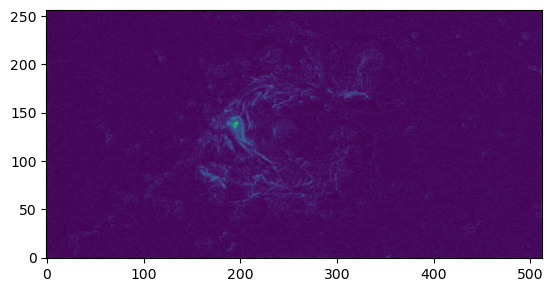

In [ ]:
plt.imshow(vector_norm(curlB)[:, :, 0].T, origin="lower")

In [ ]:
np.diff(Bz, axis=0)

NameError: name 'Bz' is not defined

In [ ]:
Dy_Bz = np.zeros_like(Bz)
Dy_Bz[:, 1:-1, :] = (Bz[:, 2:, :] - Bz[:, :-2, :]) / (2 * dy)

Dz_By = np.zeros_like(By)
Dz_By[:, :, 1:-1] = (By[:, :, 2:] - By[:, :, :-2]) / (2 * dz)


Dz_Bx = np.zeros_like(Bx)
Dz_Bx[:, :, 1:-1] = (Bx[:, :, 2:] - Bx[:, :, :-2]) / (2 * dz)

Dx_Bz = np.zeros_like(Bz)
Dx_Bz[1:-1, :, :] = (Bz[2:, :, :] - Bz[:-2, :, :]) / (2 * dx)


Dx_By = np.zeros_like(By)
Dx_By[1:-1, :, :] = (By[2:, :, :] - By[:-2, :, :]) / (2 * dx)

Dy_Bx = np.zeros_like(Bx)
Dy_Bx[:, 1:-1, :] = (Bx[:, 2:, :] - Bx[:, :-2, :]) / (2 * dy)

curl_xcomp = Dy_Bz - Dz_By
curl_ycomp = Dz_Bx - Dx_Bz
curl_zcomp = Dx_By - Dy_Bx

curlB_num = np.stack([curl_xcomp, curl_ycomp, curl_zcomp], axis=-1)
curlB_num.shape

(513, 257, 257, 3)

<matplotlib.image.AxesImage>

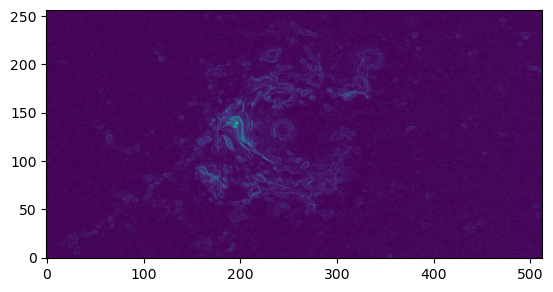

In [ ]:
plt.imshow(vector_norm(curlB_num)[:, :, 0].T, origin="lower")

In [ ]:
np.allclose(curlB[1:-1, 1:-1, 1:-1], curlB_num[1:-1, 1:-1, 1:-1])

True

In [ ]:
B = np.stack([Bx, By, Bz], axis=0)
B.shape

(3, 513, 257, 257)

In [ ]:
curl_op = Curl(h=[dx, dy, dz])
curl_findiff = curl_op(B)
curl_findiff.shape

(3, 513, 257, 257)

In [ ]:
laplacianB = laplacian_vector(B, dx, dy, dz)
laplacianB.shape

(513, 257, 257, 3)

<matplotlib.image.AxesImage>

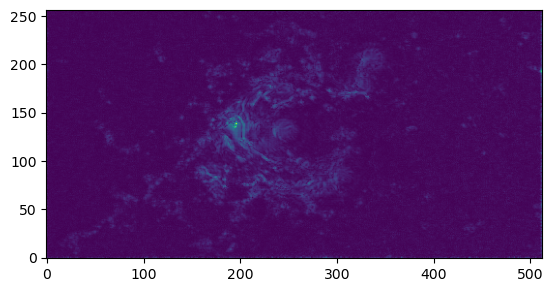

In [ ]:
plt.imshow(vector_norm(laplacianB)[:, :, 0].T, origin="lower")

In [ ]:
Dx_Dx_Bx = np.zeros_like(Bx)
Dx_Dx_Bx[1:-1, :, :] = (Bx[2:, :, :] - 2 * Bx[1:-1, :, :] + Bx[:-2, :, :]) / (dx**2)

Dy_Dy_Bx = np.zeros_like(Bx)
Dy_Dy_Bx[:, 1:-1, :] = Bx[:, 2:, :] - 2 * Bx[:, 1:-1, :] + Bx[:, :-2, :]

Dz_Dz_Bx = np.zeros_like(Bx)
Dz_Dz_Bx[:, :, 1:-1] = Bx[:, :, 2:] - 2 * Bx[:, :, 1:-1] + Bx[:, :, :-2]


Dx_Dx_By = np.zeros_like(By)
Dx_Dx_By[1:-1, :, :] = By[2:, :, :] - 2 * By[1:-1, :, :] + By[:-2, :, :]

Dy_Dy_By = np.zeros_like(By)
Dy_Dy_By[:, 1:-1, :] = By[:, 2:, :] - 2 * By[:, 1:-1, :] + By[:, :-2, :]

Dz_Dz_By = np.zeros_like(By)
Dz_Dz_By[:, :, 1:-1] = By[:, :, 2:] - 2 * By[:, :, 1:-1] + By[:, :, :-2]


Dx_Dx_Bz = np.zeros_like(Bz)
Dx_Dx_Bz[1:-1, :, :] = Bz[2:, :, :] - 2 * Bz[1:-1, :, :] + Bz[:-2, :, :]

Dy_Dy_Bz = np.zeros_like(Bz)
Dy_Dy_Bz[:, 1:-1, :] = Bz[:, 2:, :] - 2 * Bz[:, 1:-1, :] + Bz[:, :-2, :]

Dz_Dz_Bz = np.zeros_like(Bz)
Dz_Dz_Bz[:, :, 1:-1] = Bz[:, :, 2:] - 2 * Bz[:, :, 1:-1] + Bz[:, :, :-2]


laplacian_Bx = Dx_Dx_Bx + Dy_Dy_Bx + Dz_Dz_Bx
laplacian_By = Dx_Dx_By + Dy_Dy_By + Dz_Dz_By
laplacian_Bz = Dx_Dx_Bz + Dy_Dy_Bz + Dz_Dz_Bz

laplacianB_num = np.stack([laplacian_Bx, laplacian_By, laplacian_Bz], axis=-1)
laplacianB_num.shape

(513, 257, 257, 3)

<matplotlib.image.AxesImage>

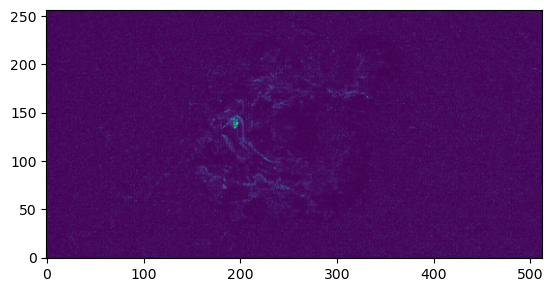

In [ ]:
plt.imshow(vector_norm(laplacianB_num)[:, :, 0].T, origin="lower")

In [ ]:
np.max(laplacianB_num)

7425.880027770996

In [ ]:
laplace = Laplacian(h=[dx, dy, dz])
laplaceB_findiff = laplace(B)
laplaceB_findiff.shape

(513, 257, 257, 3)

<matplotlib.image.AxesImage>

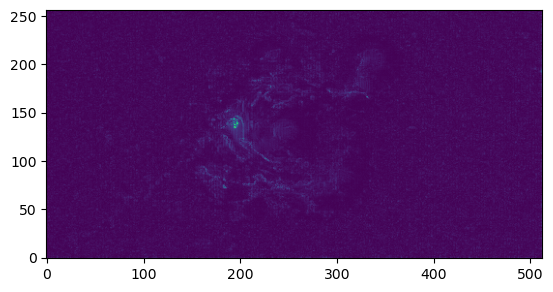

In [ ]:
plt.imshow(vector_norm(laplaceB_findiff)[:, :, 0].T, origin="lower")

In [ ]:
np.max(laplaceB_findiff)

19203.926434931265

In [ ]:
B[3, 3, 3]

array([ 20.16214943,  54.67840195, -28.71752548])

In [ ]:
laplacianB[3, 3, 3]

array([ -7.16464225, -15.67771079,  -6.09586991])

In [ ]:
laplaceB_findiff[3, 3, 3]

array([  4.9258951 , -19.53093993, -48.59743487])

In [ ]:
laplacianB_num[3, 3, 3]

array([  0.85486221,  -9.37973785, -16.03228569])

In [ ]:
np.allclose(laplaceB_findiff[1:-1, 1:-1, 1:-1], laplacianB_num[1:-1, 1:-1, 1:-1])

False

In [ ]:
divergenceB = divergence(B, dx, dy, dz)
divergenceB.shape

(513, 257, 257)

<matplotlib.image.AxesImage>

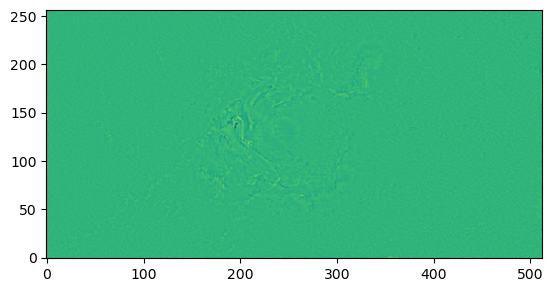

In [ ]:
plt.imshow(divergenceB[:, :, 0].T, origin="lower")

In [ ]:
Dx_Bx = np.zeros_like(Bx)
Dx_Bx[1:-1, :, :] = (Bx[2:, :, :] - Bx[:-2, :, :]) / (2 * dx)

Dy_By = np.zeros_like(By)
Dy_By[:, 1:-1, :] = (By[:, 2:, :] - By[:, :-2, :]) / (2 * dy)

Dz_Bz = np.zeros_like(Bz)
Dz_Bz[:, :, 1:-1] = (Bz[:, :, 2:] - Bz[:, :, :-2]) / (2 * dz)

divergenceB_num = Dx_Bx + Dy_By + Dz_Bz
divergenceB_num.shape

(513, 257, 257)

<matplotlib.image.AxesImage>

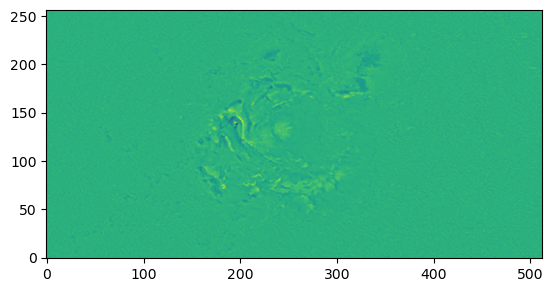

In [ ]:
plt.imshow(divergenceB_num[:, :, 0].T, origin="lower")

In [ ]:
JxB = np.cross(curlB, B, axis=-1)
JxB.shape

(513, 257, 257, 3)

<matplotlib.image.AxesImage>

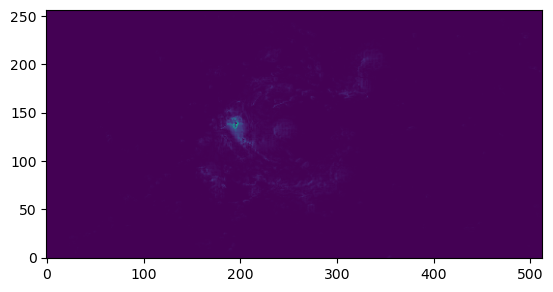

In [ ]:
plt.imshow(vector_norm(JxB)[:, :, 0].T, origin="lower")

In [ ]:
JxB_num = np.cross(curlB_num, B, axis=-1)
JxB_num.shape

(513, 257, 257, 3)

<matplotlib.image.AxesImage>

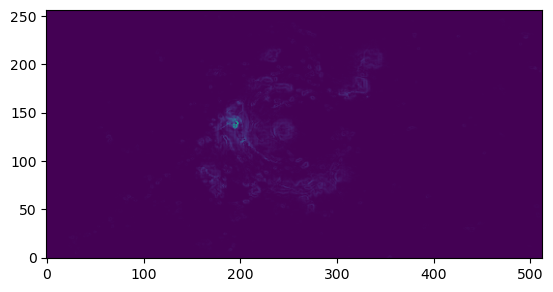

In [ ]:
plt.imshow(vector_norm(JxB_num)[:, :, 0].T, origin="lower")

In [ ]:
mesh["curlB"] = curlB.transpose(2, 1, 0, 3).reshape(-1, 3)
mesh["curlB_num"] = curlB_num.transpose(2, 1, 0, 3).reshape(-1, 3)

mesh["laplacianB"] = laplacianB.transpose(2, 1, 0, 3).reshape(-1, 3)
mesh["laplacianB_num"] = laplacianB_num.transpose(2, 1, 0, 3).reshape(-1, 3)

mesh["divergenceB"] = divergenceB.transpose(2, 1, 0).reshape(-1, 1)
mesh["divergenceB_num"] = divergenceB_num.transpose(2, 1, 0).reshape(-1, 1)

mesh["JxB"] = JxB.transpose(2, 1, 0, 3).reshape(-1, 3)
mesh["JxB_num"] = JxB_num.transpose(2, 1, 0, 3).reshape(-1, 3)

In [ ]:
surface = mesh.slice("z", origin=(0, 0, 0.1))

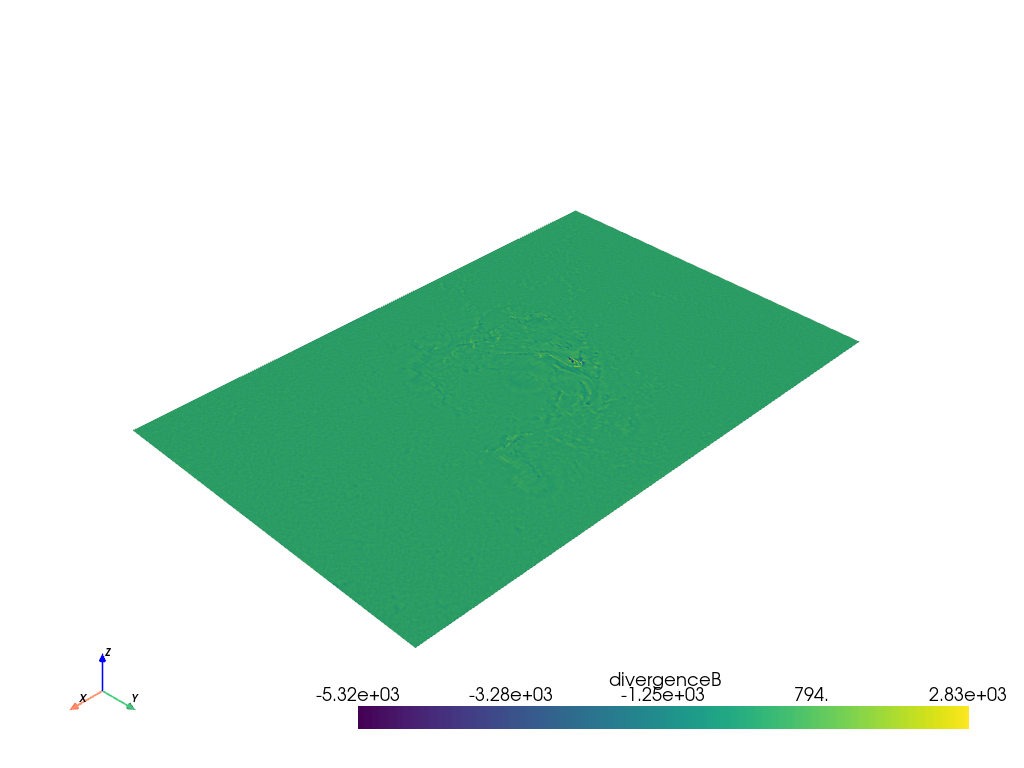

In [ ]:
surface.plot(scalars="divergenceB")

In [ ]:
from pathlib import Path

In [ ]:
p = Path(filename)

In [ ]:
mesh.save(p.with_suffix(".vtk"))

: 